In [5]:
# yunzhe and beatrice generated IsoQuant results from the WTC11 LRGASP data

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *
from proc_revisions.ss_sj_utils import *

In [2]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [3]:
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
unfilt_ab = od+expand(config['lr']['cerberus']['ab'], species='human')[0] 
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='human')[0]
major_isos = od+expand(config['lr']['analysis']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]

ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='human')[0]
ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='human')[0]

# pp_summary = '../'+expand(config['data']['p_pred']['summary'], species='human')[0]
iq_cerberus_h5 = od+expand(config['lr']['isoquant']['cerberus']['ca_annot'], species='human', obs_col='sample')[0]


iq_gtf = od+expand(config['lr']['isoquant']['gtf'], species='human')[0]
iq_ics = od+expand(config['lr']['isoquant']['cerberus']['ics'], species='human')[0]
iq_ab = od+expand(config['lr']['isoquant']['novel_ab'], species='human')[0]
iq_filt_ab = od+expand(config['lr']['isoquant']['cerberus']['ab'], species='human')[0]

ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'polya'
obs_col = 'sample'
go_gene_subset = 'protein_coding'
predom_iso_subset = 'protein_coding'
dist_gene_subset = 'protein_coding'

m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]

In [142]:
def get_iq_df_tpm(df, feat, min_tpm, gene_subset):
    dataset_cols = ['wtc11_1_3', 'wtc11_1_2', 'wtc11_1_1']
    df = df[dataset_cols+['annot_transcript_id']]
    if feat != 'triplet':
        df = add_feat(df, col='annot_transcript_id', kind=feat)
        df.drop('annot_transcript_id', inplace=True, axis=1)
        gb_col = feat
    else:
        gb_col = 'annot_transcript_id'
    df = df.groupby(gb_col).sum()
    df = df.loc[(df>=min_tpm).any(axis=1)]
    df.reset_index(inplace=True)
    
    if gene_subset:
        df['gid'] = df.ic.str.split('_', expand=True)[0]
        gene_df, _, _ = get_gtf_info(ver='v40_cerberus', how='gene', add_stable_gid=True)
        df = df.merge(gene_df[['gid_stable', 'biotype_category']], 
                      how='left',
                      left_on='gid',
                      right_on='gid_stable')
        if gene_subset == 'polya':
            gene_subset = get_polya_cats()
        else:
            gene_subset = [gene_subset]
        df = df.loc[df.biotype_category.isin(gene_subset)]
        df.drop(['gid', 'gid_stable', 'biotype_category'], axis=1, inplace=True)
    
    return df

## What % of ICs detected only in IQ have annotated microexons?

In [31]:
# take mean of each library in dataset
tl_df['tl_mean_tpm'] = tl_df.mean(axis=1)
tl_df.reset_index(inplace=True)
tl_df['tl'] = True

iq_df['iq_mean_tpm'] = iq_df.mean(axis=1)
iq_df['iq'] = True
iq_df.reset_index(inplace=True)

df = iq_df.merge(tl_df, how='outer',
                 on='ic', suffixes=('_iq', ''))
df.iq.fillna(False, inplace=True)
df.tl.fillna(False, inplace=True)
df.fillna(0, inplace=True)

df['det_cat'] = df['tl'].astype(str)+'_'+df['iq'].astype(str)

df['tl_log2_avg_tpm'] = np.log2(df.tl_mean_tpm+1)
df['iq_log2_avg_tpm'] = np.log2(df.iq_mean_tpm+1)

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


In [57]:
max_exon_len = 50

In [32]:
iq_only_ics = df.loc[(df.iq==True)&\
                     (df.tl==False)].ic.tolist()
tl_ics = df.loc[(df.tl==True)].ic.tolist()

In [62]:
ic = cerberus.read(iq_cerberus_h5).ic.copy(deep=True)
iq_ic = ic.loc[ic.Name.isin(iq_only_ics)]
tl_ic = ic.loc[ic.Name.isin(tl_ics)]

In [63]:
df, ic_df = get_exon_from_ic(iq_ic, ['v40', 'v29'])
tl_df, tl_ic_df = get_exon_from_ic(tl_ic, ['v40', 'v29'])

In [73]:
# total count of exon ECs only in IQ
ic_df['total_iq_only_ecs'] = len(iq_only_ics)

# total count of ECs only in IQ w/ >3 exons (or, at least one internal exon)
ic_df['total_iq_only_ecs_int_exon'] = len(ic_df.Name.unique().tolist())

# total count of unique ECs that have at least one microexon, that is annotated 
ic_df['exon_len'] = (ic_df.Start-ic_df.End).abs()
temp = ic_df.loc[(ic_df.novelty=='Known')&\
                 (ic_df.exon_len<=max_exon_len)]
ic_df['iq_only_ecs_known_micro'] = len(temp.Name.unique().tolist())
ic_df.head()

# mark the exons that we see in encode (wtc11) data
ic_df['ic_id'] = ic_df.Chromosome+'_'+\
                 ic_df.Strand+'_'+\
                 ic_df.Start.astype(str)+'_'+\
                 ic_df.End.astype(str)

tl_ic_df['ic_id'] = tl_ic_df.Chromosome+'_'+\
                 tl_ic_df.Strand+'_'+\
                 tl_ic_df.Start.astype(str)+'_'+\
                 tl_ic_df.End.astype(str)
temp_ids = tl_ic_df.ic_id.unique().tolist()

# how many exons from these are unique to iq
ic_df['exon_iq_only'] = ~(ic_df.ic_id.isin(temp_ids))
ic_df['iq_only_exon_total'] = len(ic_df.loc[ic_df.exon_iq_only==True].ic_id.unique().tolist())

# how many unique iq exons are annotated microexons
ic_df['annot_microexon'] = (ic_df.novelty=='Known')&\
                           (ic_df.exon_len<=max_exon_len)&\
                           (ic_df.exon_iq_only==True)
ic_df['iq_only_annot_microexon_total'] = len(ic_df.loc[ic_df.annot_microexon==True].ic_id.unique().tolist())
ic_df.head()
                                                  


,Chromosome,Strand,gene_id,Name,Start,End,source,novelty,total_iq_only_ecs,total_iq_only_ecs_int_exon,exon_len,iq_only_ecs_known_micro,ic_id,iq_only_exon_total,exon_iq_only,annot_microexon,iq_only_annot_microexon_total
0,chr1,+,ENSG00000121957,ENSG00000121957_2,108876736,108877228,"v40,v29,isoquant_wtc11",Known,13495,12299,492,1760,chr1_+_108876736_108877228,16416,True,False,672
1,chr1,+,ENSG00000121957,ENSG00000121957_2,108885274,108885578,"v40,v29,isoquant_wtc11,lapa",Known,13495,12299,304,1760,chr1_+_108885274_108885578,16416,False,False,672
2,chr1,+,ENSG00000121957,ENSG00000121957_2,108896863,108897085,"v40,v29,isoquant_wtc11,lapa",Known,13495,12299,222,1760,chr1_+_108896863_108897085,16416,False,False,672
3,chr1,+,ENSG00000121957,ENSG00000121957_2,108897491,108897627,"v40,v29,isoquant_wtc11,lapa",Known,13495,12299,136,1760,chr1_+_108897491_108897627,16416,False,False,672
4,chr1,+,ENSG00000121957,ENSG00000121957_2,108897958,108898101,"v40,v29,isoquant_wtc11,lapa",Known,13495,12299,143,1760,chr1_+_108897958_108898101,16416,False,False,672


In [74]:
ic_df.loc[ic_df.annot_microexon==True].head()

,Chromosome,Strand,gene_id,Name,Start,End,source,novelty,total_iq_only_ecs,total_iq_only_ecs_int_exon,exon_len,iq_only_ecs_known_micro,ic_id,iq_only_exon_total,exon_iq_only,annot_microexon,iq_only_annot_microexon_total
226,chr1,+,ENSG00000048707,ENSG00000048707_1,12346604,12346652,"v40,v29,isoquant_wtc11",Known,13495,12299,48,1760,chr1_+_12346604_12346652,16416,True,True,672
293,chr1,+,ENSG00000048707,ENSG00000048707_2,12346604,12346652,"v40,v29,isoquant_wtc11",Known,13495,12299,48,1760,chr1_+_12346604_12346652,16416,True,True,672
333,chr1,+,ENSG00000186364,ENSG00000186364_1,145846432,145846458,"v40,v29,lapa,isoquant_wtc11",Known,13495,12299,26,1760,chr1_+_145846432_145846458,16416,True,True,672
700,chr1,+,ENSG00000143198,ENSG00000143198_3,165632230,165632274,"v40,v29,lapa,isoquant_wtc11",Known,13495,12299,44,1760,chr1_+_165632230_165632274,16416,True,True,672
804,chr1,+,ENSG00000094975,ENSG00000094975_1,172577538,172577559,"v40,v29,isoquant_wtc11",Known,13495,12299,21,1760,chr1_+_172577538_172577559,16416,True,True,672


In [ ]:
chr1:12346604-12346652	

In [65]:
tl_ic_df.head()

,Chromosome,Strand,gene_id,Name,Start,End,source,novelty,ic_id
0,chr1,+,ENSG00000156875,ENSG00000156875_1,100049908,100050004,"v40,v29,lapa,gtex,isoquant_wtc11",Known,chr1_+_100049908_100050004
1,chr1,+,ENSG00000156875,ENSG00000156875_1,100058665,100058728,"v40,v29,lapa,gtex,isoquant_wtc11",Known,chr1_+_100058665_100058728
2,chr1,+,ENSG00000156875,ENSG00000156875_1,100059877,100060005,"v40,v29,lapa,gtex,isoquant_wtc11",Known,chr1_+_100059877_100060005
3,chr1,+,ENSG00000156875,ENSG00000156875_1,100061834,100061949,"v40,v29,lapa,gtex,isoquant_wtc11",Known,chr1_+_100061834_100061949
4,chr1,+,ENSG00000156875,ENSG00000156875_1,100067976,100068195,"v40,v29,lapa,gtex,isoquant_wtc11",Known,chr1_+_100067976_100068195


In [50]:
# BSG gene
# temp = ic_df.loc[ic_df.Name=='ENSG00000172270_1']
# temp['exon_len'] = (temp['Start']-temp['End']).abs()
# temp

In [ ]:
chr19:582305-582330

## How highly-expressed are genes from ICs that are detected only in ENCODE?

In [206]:
# gene - level 
iq_df = pd.read_csv(iq_filt_ab, sep='\t')
iq_df = get_iq_df_tpm(iq_df, 'ic', min_tpm=min_tpm, gene_subset=gene_subset)

tl_df = pd.read_csv(filt_ab, sep='\t')
tl_df, tids = get_tpm_table(tl_df, 
                         how='ic',
                         min_tpm=min_tpm,
                         gene_subset=gene_subset,
                         sample=['wtc11'])

# take mean of each library in dataset
tl_df['tl_mean_tpm'] = tl_df.mean(axis=1)
tl_df.reset_index(inplace=True)
tl_df['tl'] = True

iq_df['iq_mean_tpm'] = iq_df.mean(axis=1)
iq_df['iq'] = True
iq_df.reset_index(inplace=True)

df = iq_df.merge(tl_df, how='outer',
                 on='ic', suffixes=('_iq', ''))
df.iq.fillna(False, inplace=True)
df.tl.fillna(False, inplace=True)
df.fillna(0, inplace=True)

df['det_cat'] = df['tl'].astype(str)+'_'+df['iq'].astype(str)

df['tl_log2_avg_tpm'] = np.log2(df.tl_mean_tpm+1)
df['iq_log2_avg_tpm'] = np.log2(df.iq_mean_tpm+1)

df['gid'] = df['ic'].str.split('_', expand=True)[0] 

# ic expression
ic_df = df.copy(deep=True)

# det of genes
x = 'tl_mean_tpm'
y = 'iq_mean_tpm'
df = df[[x, y, 'iq', 'tl', 'gid']].groupby('gid').agg({x:sum,
                                                          y:sum,
                                                          'iq':max,
                                                          'tl':max}).reset_index()
df['det_cat'] = df['tl'].astype(str)+'_'+df['iq'].astype(str)

# summary
temp3 = df[['det_cat', 'gid']].reset_index().groupby(['det_cat']).count().reset_index()
temp3['total'] = temp3['gid'].sum(axis=0)
temp3['perc'] = (temp3['gid']/temp3['total'])*100
temp3

Calculating ic TPM values
Subsetting for ['wtc11'] samples
Subsetting for polya genes
Enforcing minimum TPM
Total # ics detected: 145392
# ics >= 1 tpm: 47564
Applying gene type and novelty subset
Number of ics reported: 47357


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


,det_cat,index,gid,total,perc
0,False_True,1423,1423,15147,9.394600
1,True_False,1143,1143,15147,7.546049
2,True_True,12581,12581,15147,83.059352


In [208]:
# get the ECs that are in TL but not the other
print(len(ic_df.index))
gids = ic_df.loc[ic_df.det_cat=='True_False', 'gid'].unique().tolist()
print(len(gids))
temp2 = df.loc[df.gid.isin(gids)][['gid', 'tl_mean_tpm', 'iq_mean_tpm']]
temp2['tl_log2_mean_tpm'] = np.log2(temp2['tl_mean_tpm'].astype(float)+1)
temp2['iq_log2_mean_tpm'] = np.log2(temp2['iq_mean_tpm'].astype(float)+1)
temp2.head()
# compare expression of genes that had ECs unique to TL
x = 'tl_log2_mean_tpm'
y = 'iq_log2_mean_tpm'
sns.jointplot(data=temp2, x=x, y=y)

temp2['diff'] = (temp2[x]-temp2[y]).abs()
temp2.sort_values(by='diff', ascending=False).head(10)

,gid,tl_mean_tpm,iq_mean_tpm,tl_log2_mean_tpm,iq_log2_mean_tpm
0,ENSG00000000003,146.434826,42.350945,7.203934,5.437992
2,ENSG00000000419,21.871016,40.009087,4.515449,5.357872
4,ENSG00000000460,26.491408,10.271909,4.780909,3.494660
5,ENSG00000001036,114.043008,23.106709,6.846029,4.591363
6,ENSG00000001084,64.459383,41.598716,6.032528,5.412738


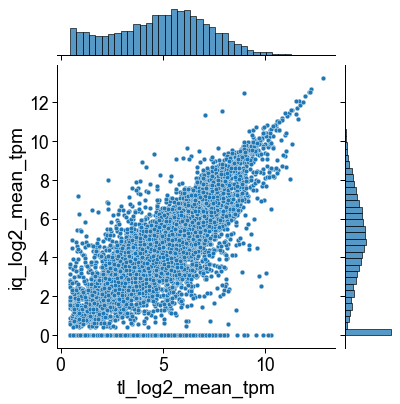

,gid,tl_mean_tpm,iq_mean_tpm,tl_log2_mean_tpm,iq_log2_mean_tpm,diff
3529,ENSG00000115053,1237.574587,0.0,10.274465,0.0,10.274465
8882,ENSG00000165280,1130.500935,0.0,10.144022,0.0,10.144022
2566,ENSG00000105568,945.819542,0.0,9.886946,0.0,9.886946
2379,ENSG00000104341,750.515410,0.0,9.553659,0.0,9.553659
7490,ENSG00000153147,548.772490,0.0,9.102691,0.0,9.102691
9894,ENSG00000171490,501.864927,0.0,8.974027,0.0,8.974027
2268,ENSG00000103194,500.542010,0.0,8.970227,0.0,8.970227
11912,ENSG00000189091,394.838572,0.0,8.628768,0.0,8.628768
1300,ENSG00000082898,279.792588,0.0,8.133361,0.0,8.133361
9355,ENSG00000167930,277.414746,0.0,8.121092,0.0,8.121092


## Calculate and compare sample-level triplets

In [5]:
min_tpm = 1
ca = cerberus.read(cerberus_h5)

In [6]:
iq_df = pd.read_csv(iq_filt_ab, sep='\t')
iq_df = get_iq_df_tpm(iq_df, 'triplet', min_tpm=min_tpm, gene_subset=gene_subset)
iq_ids = iq_df.annot_transcript_id.tolist()

# tl_df = pd.read_csv(filt_ab, sep='\t')
# tl_df, tids = get_tpm_table(tl_df, 
#                          how='iso',
#                          min_tpm=min_tpm,
#                          gene_subset=None,
#                          sample=['wtc11'])

ca = cerberus.read(cerberus_h5)
df = ca.get_subset_triplets(iq_ids, source='iq_wtc11')

# save wtc11 iq triplets
df.to_csv('wtc11_isoquant_triplets.tsv', sep='\t')

ca.triplets = pd.concat([ca.triplets, df], axis=0)

# rename wtc11 cerberus triplet sources
ca.triplets.loc[(ca.triplets.source=='sample_det')&(ca.triplets['sample']=='wtc11'),
                'source'] = 'encode_wtc11'
ca.triplets.loc[ca.triplets.source=='iq_wtc11', 'gid'] = ca.triplets.loc[ca.triplets.source=='iq_wtc11', 'gene_id']


ca.write('iq_cerb_wtc11_triplets.h5')

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/pandas/core/generic.py:2718: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['Chromosome', 'Strand', 'source', 'Name'], dtype='object')]

  encoding=encoding,
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/pandas/core/generic.py:2718: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['source', 'gid', 'sector', 'gname', 'sample', 'gene_id'], dtype='object')]

  encoding=encoding,


In [7]:
ca = cerberus.read('iq_cerb_wtc11_triplets.h5')


In [8]:
ca.triplets.source.unique()

array(['v40', 'gtex', 'lapa', 'v29', 'all', 'obs_det', 'sample_det',
       'encode_wtc11', 'obs_major', 'sample_major', 'obs_mm_det',
       'obs_mm_major', 'iq_wtc11'], dtype=object)

In [9]:
df = compute_dists([ca, ca],
                   ['iq_wtc11', 
                   'encode_wtc11'],
                   gene_subsets=[dist_gene_subset, dist_gene_subset],
                   ver=[ver,  ver],
                   gene_merge=['gid', 'gid'])

In [17]:
ca.triplets.columns


Index(['source', 'gid', 'n_tss', 'n_tes', 'n_ic', 'n_iso', 'splicing_ratio',
       'tss_ratio', 'tes_ratio', 'spl_ratio', 'sector', 'gname', 'sample',
       'gene_tpm', 'gene_id'],
      dtype='object')

In [10]:
df.to_csv('iq_vs_cerb_wtc11_trip_dists.tsv', sep='\t')

In [11]:
df.head()


,source_iq_wtc11,gid,n_tss_iq_wtc11,n_tes_iq_wtc11,n_ic_iq_wtc11,n_iso_iq_wtc11,splicing_ratio_iq_wtc11,tss_ratio_iq_wtc11,tes_ratio_iq_wtc11,spl_ratio_iq_wtc11,...,spl_ratio_encode_wtc11,sector_encode_wtc11,gname_encode_wtc11,sample_encode_wtc11,gene_tpm_encode_wtc11,gene_id_encode_wtc11,gid_stable_encode_wtc11,biotype_encode_wtc11,dist,z_score
0,iq_wtc11,ENSG00000000003,2.0,2.0,2.0,2.0,1.000000,0.400000,0.400000,0.200000,...,0.250000,tes,TSPAN6,wtc11,131.675995,NaN,ENSG00000000003,protein_coding,0.227403,1.248470
1,iq_wtc11,ENSG00000000419,1.0,1.0,4.0,4.0,4.000000,0.166667,0.166667,0.666667,...,0.666667,splicing,DPM1,wtc11,21.533937,NaN,ENSG00000000419,protein_coding,0.000000,-1.417879
2,iq_wtc11,ENSG00000000457,1.0,2.0,3.0,3.0,2.000000,0.200000,0.400000,0.400000,...,0.181818,tes,SCYL3,wtc11,9.735471,NaN,ENSG00000000457,protein_coding,0.171430,0.592174
3,iq_wtc11,ENSG00000000460,2.0,4.0,6.0,6.0,2.000000,0.250000,0.500000,0.250000,...,0.307692,mixed,C1orf112,wtc11,30.262556,NaN,ENSG00000000460,protein_coding,0.045517,-0.884182
4,iq_wtc11,ENSG00000001036,1.0,2.0,2.0,2.0,1.333333,0.230769,0.461538,0.307692,...,0.333333,mixed,FUCA2,wtc11,101.700195,NaN,ENSG00000001036,protein_coding,0.056897,-0.750745


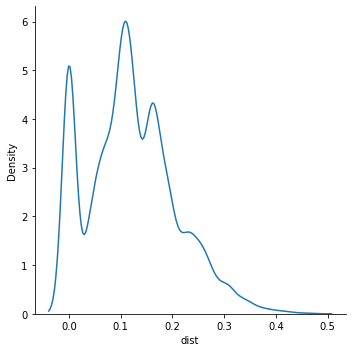

In [13]:
sns.displot(data=df, x='dist', kind='kde')

In [15]:
df.sort_values(by='dist', ascending=False)[['gid', 'n_tss_iq_wtc11','n_ic_iq_wtc11','n_tes_iq_wtc11',
                                            'n_tss_encode_wtc11', 'n_ic_encode_wtc11', 'n_tes_encode_wtc11']]

,gid,n_tss_iq_wtc11,n_ic_iq_wtc11,n_tes_iq_wtc11,n_tss_encode_wtc11,n_ic_encode_wtc11,n_tes_encode_wtc11
2803,ENSG00000110851,1.0,5.0,1.0,1.0,1.0,3.0
9366,ENSG00000177045,1.0,4.0,1.0,5.0,2.0,1.0
129,ENSG00000007866,1.0,6.0,1.0,6.0,5.0,1.0
3632,ENSG00000119711,1.0,2.0,1.0,1.0,1.0,6.0
6823,ENSG00000154511,1.0,3.0,1.0,1.0,1.0,4.0
...,...,...,...,...,...,...,...
1138,ENSG00000082014,2.0,2.0,1.0,2.0,2.0,1.0
4985,ENSG00000134909,1.0,2.0,2.0,1.0,2.0,2.0
1137,ENSG00000081923,1.0,2.0,1.0,1.0,2.0,1.0
7971,ENSG00000165502,1.0,1.0,1.0,1.0,1.0,1.0


In [16]:
df.sort_values(by='dist', ascending=True)[['gid', 'n_tss_iq_wtc11','n_ic_iq_wtc11','n_tes_iq_wtc11',
                                            'n_tss_encode_wtc11', 'n_ic_encode_wtc11', 'n_tes_encode_wtc11']].head()

,gid,n_tss_iq_wtc11,n_ic_iq_wtc11,n_tes_iq_wtc11,n_tss_encode_wtc11,n_ic_encode_wtc11,n_tes_encode_wtc11
5453,ENSG00000138400,1.0,1.0,1.0,1.0,1.0,1.0
11211,ENSG00000213920,1.0,2.0,1.0,1.0,2.0,1.0
6569,ENSG00000151224,1.0,2.0,1.0,1.0,2.0,1.0
4018,ENSG00000124491,1.0,1.0,1.0,1.0,1.0,1.0
4016,ENSG00000124466,2.0,2.0,1.0,2.0,2.0,1.0


## Look at detection and expression of shared ICs

In [74]:
min_tpm = 1
ca = cerberus.read(cerberus_h5)

In [75]:
def get_iq_df_tpm(df, feat, min_tpm, gene_subset):
    dataset_cols = ['wtc11_1_3', 'wtc11_1_2', 'wtc11_1_1']
    df = df[dataset_cols+['annot_transcript_id']]
    if feat != 'triplet':
        df = add_feat(df, col='annot_transcript_id', kind=feat)
        df.drop('annot_transcript_id', inplace=True, axis=1)
        gb_col = feat
    else:
        gb_col = 'annot_transcript_id'
    df = df.groupby(gb_col).sum()
    df = df.loc[(df>=min_tpm).any(axis=1)]
    df.reset_index(inplace=True)
    
    if gene_subset:
        df['gid'] = df.ic.str.split('_', expand=True)[0]
        gene_df, _, _ = get_gtf_info(ver='v40_cerberus', how='gene', add_stable_gid=True)
        df = df.merge(gene_df[['gid_stable', 'biotype_category']], 
                      how='left',
                      left_on='gid',
                      right_on='gid_stable')
        if gene_subset == 'polya':
            gene_subset = get_polya_cats()
        else:
            gene_subset = [gene_subset]
        df = df.loc[df.biotype_category.isin(gene_subset)]
        df.drop(['gid', 'gid_stable', 'biotype_category'], axis=1, inplace=True)
    
    return df



In [169]:
iq_df = pd.read_csv(iq_filt_ab, sep='\t')
iq_df = get_iq_df_tpm(iq_df, 'ic', min_tpm=min_tpm, gene_subset=gene_subset)

tl_df = pd.read_csv(filt_ab, sep='\t')
tl_df, tids = get_tpm_table(tl_df, 
                         how='ic',
                         min_tpm=min_tpm,
                         gene_subset=gene_subset,
                         sample=['wtc11'])

# take mean of each library in dataset
tl_df['tl_mean_tpm'] = tl_df.mean(axis=1)
tl_df.reset_index(inplace=True)
tl_df['tl'] = True

iq_df['iq_mean_tpm'] = iq_df.mean(axis=1)
iq_df['iq'] = True
iq_df.reset_index(inplace=True)

df = iq_df.merge(tl_df, how='outer',
                 on='ic', suffixes=('_iq', ''))
df.iq.fillna(False, inplace=True)
df.tl.fillna(False, inplace=True)
df.fillna(0, inplace=True)

df['det_cat'] = df['tl'].astype(str)+'_'+df['iq'].astype(str)

df['tl_log2_avg_tpm'] = np.log2(df.tl_mean_tpm+1)
df['iq_log2_avg_tpm'] = np.log2(df.iq_mean_tpm+1)


df[['iq', 'tl']].reset_index().groupby(['iq', 'tl']).count().reset_index()

Calculating ic TPM values
Subsetting for ['wtc11'] samples
Subsetting for polya genes
Enforcing minimum TPM
Total # ics detected: 145392
# ics >= 1 tpm: 47564
Applying gene type and novelty subset
Number of ics reported: 47357


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  app.launch_new_instance()


,iq,tl,index
0,False,True,24736
1,True,False,13495
2,True,True,22621


In [170]:
sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

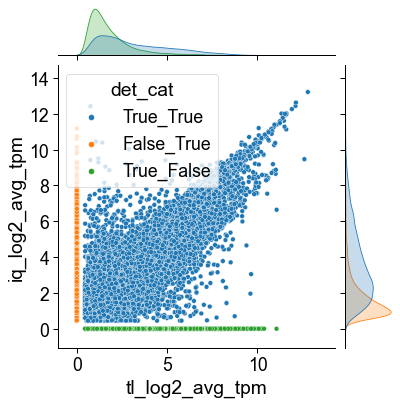

In [171]:
sns.jointplot(df, y='iq_log2_avg_tpm', x='tl_log2_avg_tpm', hue='det_cat')

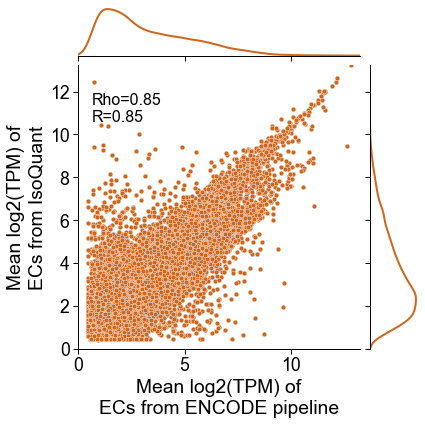

In [172]:
# how well-correlated are the ICs det. in both?
x = 'tl_mean_tpm'
y = 'iq_mean_tpm'
temp = df.loc[df.det_cat=='True_True']
temp = temp[['ic', x, y]].set_index('ic')
rho, p = st.spearmanr(temp[x].tolist(), temp[y].tolist())
r, p2 = st.pearsonr(temp[x].tolist(), temp[y].tolist())

# add pseudocounts and plot log2tpm
temp = temp+1
temp = np.log2(temp)
lim = (0, max(temp[x].max(), temp[y].max()))

c_dict, order= get_biosample_colors(species='human')

g = sns.JointGrid(data=temp, x=x, y=y, ylim=lim, xlim=lim)
g.plot_joint(sns.scatterplot, color=c_dict['wtc11'])
g.plot_marginals(sns.kdeplot, color=c_dict['wtc11'], linewidth=2)

# g.plot_marginals(sns.distplot, kde=True)
# g = sns.jointplot(temp, x=x, y=y, color=c_dict[sample],
#                   ylim=lim, xlim=lim, kind='kde', marginal_kws={'linewidth':2}) 
for d, ax in zip([x,y], ['x','y']):
    label = 'WTC11'
    label += f" Rep. {'_'.join(d.rsplit('_',2)[-2:])}"
    if ax == 'x':
        g.ax_joint.set_xlabel('Mean log2(TPM) of\nECs from ENCODE pipeline')
    elif ax == 'y':
        g.ax_joint.set_ylabel('Mean log2(TPM) of\nECs from IsoQuant')
plt.text(.05, .8, 'Rho={:.2f}\nR={:.2f}'.format(rho,r), transform=g.ax_joint.transAxes,
          size=16)

# fname = 'figures/shared_ec_wtc11_iq_v_cerb_corr.pdf'
fname = 'figures/shared_ec_wtc11_iq_v_cerb_corr.png'

plt.savefig(fname, dpi=500)

## How correlated are shared genes?

In [158]:
# gene - level 
iq_df = pd.read_csv(iq_filt_ab, sep='\t')
iq_df = get_iq_df_tpm(iq_df, 'ic', min_tpm=min_tpm, gene_subset=gene_subset)

tl_df = pd.read_csv(filt_ab, sep='\t')
tl_df, tids = get_tpm_table(tl_df, 
                         how='ic',
                         min_tpm=min_tpm,
                         gene_subset=gene_subset,
                         sample=['wtc11'])

# take mean of each library in dataset
tl_df['tl_mean_tpm'] = tl_df.mean(axis=1)
tl_df.reset_index(inplace=True)
tl_df['tl'] = True

iq_df['iq_mean_tpm'] = iq_df.mean(axis=1)
iq_df['iq'] = True
iq_df.reset_index(inplace=True)

df = iq_df.merge(tl_df, how='outer',
                 on='ic', suffixes=('_iq', ''))
df.iq.fillna(False, inplace=True)
df.tl.fillna(False, inplace=True)
df.fillna(0, inplace=True)

df['det_cat'] = df['tl'].astype(str)+'_'+df['iq'].astype(str)

df['tl_log2_avg_tpm'] = np.log2(df.tl_mean_tpm+1)
df['iq_log2_avg_tpm'] = np.log2(df.iq_mean_tpm+1)

# det of genes
x = 'tl_mean_tpm'
y = 'iq_mean_tpm'
df['gid'] = df['ic'].str.split('_', expand=True)[0] 
df = df[[x, y, 'iq', 'tl', 'gid']].groupby('gid').agg({x:sum,
                                                          y:sum,
                                                          'iq':max,
                                                          'tl':max}).reset_index()
df['det_cat'] = df['tl'].astype(str)+'_'+df['iq'].astype(str)

# summary
temp3 = df[['det_cat', 'gid']].reset_index().groupby(['det_cat']).count().reset_index()
temp3['total'] = temp3['gid'].sum(axis=0)
temp3['perc'] = (temp3['gid']/temp3['total'])*100
temp3

Calculating ic TPM values
Subsetting for ['wtc11'] samples
Subsetting for polya genes
Enforcing minimum TPM
Total # ics detected: 145392
# ics >= 1 tpm: 47564
Applying gene type and novelty subset
Number of ics reported: 47357


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


,det_cat,index,gid,total,perc
0,False_True,1423,1423,15147,9.394600
1,True_False,1143,1143,15147,7.546049
2,True_True,12581,12581,15147,83.059352


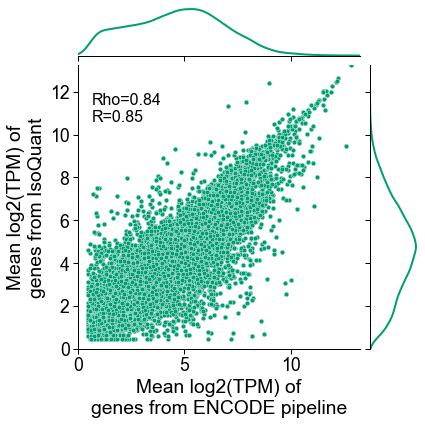

In [160]:
# how well-correlated are the known polyA genes det. in both?
x = 'tl_mean_tpm'
y = 'iq_mean_tpm'
temp = df.loc[df.det_cat=='True_True']

temp = temp[['gid', x, y]].set_index('gid')
rho, p = st.spearmanr(temp[x].tolist(), temp[y].tolist())
r, p2 = st.pearsonr(temp[x].tolist(), temp[y].tolist())

# add pseudocounts and plot log2tpm
temp = temp+1
temp = np.log2(temp)
lim = (0, max(temp[x].max(), temp[y].max()))

ic_colors, order = get_ic_nov_colors()
c = ic_colors['Known']

g = sns.JointGrid(data=temp, x=x, y=y, ylim=lim, xlim=lim)
g.plot_joint(sns.scatterplot, color=c)
g.plot_marginals(sns.kdeplot, color=c, linewidth=2)


sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
for d, ax in zip([x,y], ['x','y']):
    label = 'WTC11'
    label += f" Rep. {'_'.join(d.rsplit('_',2)[-2:])}"
    if ax == 'x':
        g.ax_joint.set_xlabel('Mean log2(TPM) of\ngenes from ENCODE pipeline')
    elif ax == 'y':
        g.ax_joint.set_ylabel('Mean log2(TPM) of\ngenes from IsoQuant')
plt.text(.05, .8, 'Rho={:.2f}\nR={:.2f}'.format(rho,r), transform=g.ax_joint.transAxes,
          size=16)

# fname = 'figures/shared_gene_wtc11_iq_v_cerb_corr.pdf'
fname = 'figures/shared_gene_wtc11_iq_v_cerb_corr.png'

plt.savefig(fname, dpi=500)

MannwhitneyuResult(statistic=3649602.5, pvalue=9.151146282193938e-16)

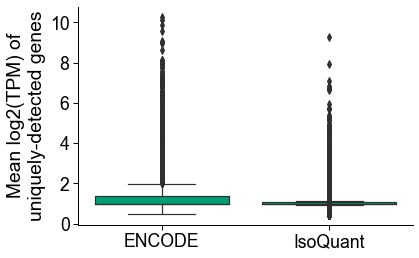

In [168]:
## How highly-expressed are genes for the different detection categories?
uniq_df = df.loc[df.det_cat.str.contains('False')]
uniq_df.head()
uniq_df['det'] = False
uniq_df.loc[uniq_df.det_cat=='True_False', 'det'] = 'ENCODE'
uniq_df.loc[uniq_df.det_cat=='False_True', 'det'] = 'IsoQuant'
uniq_df.drop('det_cat', axis=1, inplace=True)
uniq_df = uniq_df.melt(id_vars=['det', 'gid'])
uniq_df = uniq_df.loc[uniq_df.value>0] # get rid of things that aren't expressed
uniq_df.rename({'value': 'mean_tpm'}, axis=1, inplace=True)
uniq_df['mean_tpm_pseudo'] = uniq_df['mean_tpm'].astype(float)+1
uniq_df.dtypes

uniq_df['mean_log2tpm'] = np.log2(uniq_df.mean_tpm_pseudo)
uniq_df
temp_c_dict, order = get_ic_nov_colors()
c = temp_c_dict['Known']
ax = sns.boxplot(data=uniq_df, y='mean_log2tpm', x='det', color=c, saturation=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set(xlabel='', ylabel='Mean log2(TPM) of\nuniquely-detected genes')

fname = 'figures/iq_v_cerb_uniq_gene_tpms.pdf'
plt.savefig(fname, dpi=500)

x = uniq_df.loc[uniq_df.det=='ENCODE', 'mean_log2tpm'].tolist()
y = uniq_df.loc[uniq_df.det=='IsoQuant', 'mean_log2tpm'].tolist()
st.mannwhitneyu(x,y)

## What do the ECs look like by novelty category?

In [177]:
def plot_ic_novelty_per_det_cat(df,
                    ofile,
                    novs=None,
                    ylim=None):
    """
    Plot number of intron chains per novelty category.

    Parameters:
        fname (str): Cerberus annotation file name
        oprefix (str): Place to save
        ylim (int): y limit of resultant plot
        pass_list (list of str): List of ic IDs to retain
        save_type (str): Choose from 'pdf' or 'png'
    """

    sns.set_context('paper', font_scale=1.6)

    temp = df.copy(deep=True)

    temp = temp[['Name', 'novelty', 'det_hr']]
    temp = temp.groupby(['novelty', 'det_hr']).count()
    temp.reset_index(inplace=True)
    
    if not novs:
        novs = temp.novelty.unique().tolist()
    else:
        temp = temp.loc[temp.novelty.isin(novs)]

    temp.rename({'Name': 'counts'}, axis=1, inplace=True)
    print(temp)
    c_dict, order = get_ic_nov_colors(cats=novs)

    temp = temp.loc[temp.novelty.isin(novs)].copy(deep=True)
    complete = temp[['counts']].sum(axis=0)
    print('Number of complete intron chains: {}'.format(complete))

    # actual plotting
    sns.set_context('paper', font_scale=2)
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['pdf.fonttype'] = 42
    # plt.figure(figsize=(4,6))
    plt.figure(figsize=(5,4))
    
    c_dict, order = get_ic_nov_colors(cats=novs)
    temp['novelty'] = temp['novelty'].astype(str).astype('category')
    temp['novelty'] = temp['novelty'].cat.reorder_categories(order, ordered=True)
    cats = ['ENCODE + IsoQuant', 'ENCODE only', 'IsoQuant only']
    temp['det_hr'] = temp['det_hr'].astype('category')
    temp['det_hr'] = temp['det_hr'].cat.reorder_categories(cats, ordered=True)

    # g = sns.catplot(data=temp, x='novelty',
    #             y='counts', kind='bar',
    #             saturation=1,
    #             hue='det_hr',
    #             # hue_order=cats,
    #             palette=c_dict,
    #             order=order)
    g = sns.barplot(data=temp,
            x='novelty',
            y='counts',
            hue='det_hr',
            order=order,
            hue_order=cats,
            saturation=1)
    g.spines['right'].set_visible(False)
    g.spines['top'].set_visible(False)
    g.set(ylabel='# WTC11 ECs', xlabel='')
    g.tick_params(axis="x", rotation=45)
    

    
    for bar_group, cat in zip(g.containers, cats):
        for bar, cat2 in zip(bar_group, order):
            c = c_dict[cat2]
            c_dict_2, order_2 = get_shade_colors(c, cats)
            bar.set_facecolor(c_dict_2[cat])

    # add percentage labels
    # ax = g.axes[0,0]
    # add_perc(ax, temp, 'counts')

    if ylim:
        g.set(ylim=(0,ylim))

    # save figure
    plt.savefig(ofile, dpi=500, bbox_inches='tight')

    plt.show()
    plt.clf()

In [173]:
ca = cerberus.read(iq_cerberus_h5)

In [174]:
iq_df = pd.read_csv(iq_filt_ab, sep='\t')
iq_df = get_iq_df_tpm(iq_df, 'ic', min_tpm=min_tpm, gene_subset=gene_subset)

tl_df = pd.read_csv(filt_ab, sep='\t')
tl_df, tids = get_tpm_table(tl_df, 
                         how='ic',
                         min_tpm=min_tpm,
                         gene_subset=gene_subset,
                         sample=['wtc11'])

# take mean of each library in dataset
tl_df['tl_mean_tpm'] = tl_df.mean(axis=1)
tl_df.reset_index(inplace=True)
tl_df['tl'] = True

iq_df['iq_mean_tpm'] = iq_df.mean(axis=1)
iq_df['iq'] = True
iq_df.reset_index(inplace=True)

df = iq_df.merge(tl_df, how='outer',
                 on='ic', suffixes=('_iq', ''))
df.iq.fillna(False, inplace=True)
df.tl.fillna(False, inplace=True)
df.fillna(0, inplace=True)

df['det_cat'] = df['tl'].astype(str)+'_'+df['iq'].astype(str)

df['tl_log2_avg_tpm'] = np.log2(df.tl_mean_tpm+1)
df['iq_log2_avg_tpm'] = np.log2(df.iq_mean_tpm+1)


df[['iq', 'tl']].reset_index().groupby(['iq', 'tl']).count().reset_index()

Calculating ic TPM values
Subsetting for ['wtc11'] samples
Subsetting for polya genes
Enforcing minimum TPM
Total # ics detected: 145392
# ics >= 1 tpm: 47564
Applying gene type and novelty subset
Number of ics reported: 47357


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  app.launch_new_instance()


,iq,tl,index
0,False,True,24736
1,True,False,13495
2,True,True,22621


In [175]:
df = df.merge(ca.ic[['Name', 'novelty']], how='left', left_on='ic', right_on='Name')

   novelty             det_hr  counts
0      ISM  ENCODE + IsoQuant     720
1      ISM        ENCODE only    2291
2      ISM      IsoQuant only    1485
3    Known  ENCODE + IsoQuant   16838
4    Known        ENCODE only   11026
5    Known      IsoQuant only    4608
6      NIC  ENCODE + IsoQuant    3989
7      NIC        ENCODE only    6984
8      NIC      IsoQuant only    3809
9      NNC  ENCODE + IsoQuant    1074
10     NNC        ENCODE only    4435
11     NNC      IsoQuant only    3593
Number of complete intron chains: counts    60852
dtype: int64


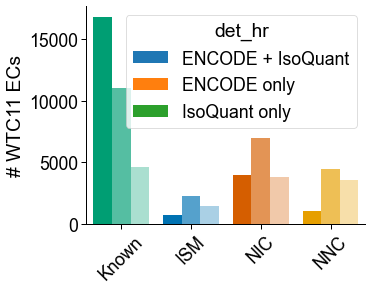

<Figure size 432x288 with 0 Axes>

In [178]:
# How many intersect per novelty category?
det_map = {'True_False': 'ENCODE only',
           'True_True': 'ENCODE + IsoQuant',
           'False_True': 'IsoQuant only'}
df['det_hr'] = df.det_cat.map(det_map)
temp = plot_ic_novelty_per_det_cat(df,
                            'figures/wtc11_iq_encode_det_per_nov.pdf',
                            novs=['Known', 'ISM', 'NIC', 'NNC'])

## What ECs have large discrepancies?

In [181]:
df.head()

,index,ic,wtc11_1_3_iq,wtc11_1_2_iq,wtc11_1_1_iq,iq_mean_tpm,iq,wtc11_1_3,wtc11_1_2,wtc11_1_1,tl_mean_tpm,tl,det_cat,tl_log2_avg_tpm,iq_log2_avg_tpm,Name,novelty,det_hr
0,0.0,ENSG00000000003_1,83.495464,19.932929,20.710954,41.379782,True,136.354672,140.624488,116.603488,131.194216,True,True_True,7.046515,5.405304,ENSG00000000003_1,Known,ENCODE + IsoQuant
1,1.0,ENSG00000000003_2,0.613092,2.300396,0.000000,0.971163,True,0.000000,0.000000,0.000000,0.000000,False,False_True,0.000000,0.979047,ENSG00000000003_2,Known,IsoQuant only
2,2.0,ENSG00000000005_3,2.189614,2.300396,4.616112,3.035374,True,0.000000,0.000000,0.000000,0.000000,False,False_True,0.000000,2.012702,ENSG00000000005_3,ISM,IsoQuant only
3,3.0,ENSG00000000419_1,37.497144,37.956529,25.003938,33.485870,True,26.081263,11.558177,13.584872,17.074771,True,True_True,4.175905,5.107933,ENSG00000000419_1,Known,ENCODE + IsoQuant
4,4.0,ENSG00000000419_16,1.368509,0.000000,1.154028,0.840846,True,0.000000,0.000000,0.000000,0.000000,False,False_True,0.000000,0.880369,ENSG00000000419_16,Known,IsoQuant only


In [180]:
df.loc[(df.det_cat=='False_True')&(df.iq_log2_avg_tpm>10)]

,index,ic,wtc11_1_3_iq,wtc11_1_2_iq,wtc11_1_1_iq,iq_mean_tpm,iq,wtc11_1_3,wtc11_1_2,wtc11_1_1,tl_mean_tpm,tl,det_cat,tl_log2_avg_tpm,iq_log2_avg_tpm,Name,novelty,det_hr
4073,4073.0,ENSG00000089157_1,2143.446204,3024.272717,1799.614222,2322.444381,True,0.0,0.0,0.0,0.0,False,False_True,0.0,11.182049,ENSG00000089157_1,Known,IsoQuant only
6919,6919.0,ENSG00000105372_4,443.396879,3144.870962,1126.331252,1571.533031,True,0.0,0.0,0.0,0.0,False,False_True,0.0,10.618875,ENSG00000105372_4,Known,IsoQuant only
21444,21444.0,ENSG00000161203_1,1008.426829,1204.556201,1162.498487,1125.160506,True,0.0,0.0,0.0,0.0,False,False_True,0.0,10.137197,ENSG00000161203_1,Known,IsoQuant only
25888,25888.0,ENSG00000172270_6,1483.567640,2083.617911,1564.638750,1710.608100,True,0.0,0.0,0.0,0.0,False,False_True,0.0,10.741137,ENSG00000172270_6,Known,IsoQuant only


In [182]:
df.loc[(df.det_cat=='True_False')&(df.tl_log2_avg_tpm>10)]

,index,ic,wtc11_1_3_iq,wtc11_1_2_iq,wtc11_1_1_iq,iq_mean_tpm,iq,wtc11_1_3,wtc11_1_2,wtc11_1_1,tl_mean_tpm,tl,det_cat,tl_log2_avg_tpm,iq_log2_avg_tpm,Name,novelty,det_hr
43391,0.0,ENSG00000115053_1,0.0,0.0,0.0,0.0,False,1240.003898,1031.567308,1278.110073,1183.227093,True,True_False,10.209730,0.0,ENSG00000115053_1,Known,ENCODE only
46503,0.0,ENSG00000132341_1,0.0,0.0,0.0,0.0,False,1225.819352,1392.760343,934.526010,1184.368568,True,True_False,10.211120,0.0,ENSG00000132341_1,Known,ENCODE only
50390,0.0,ENSG00000150753_1,0.0,0.0,0.0,0.0,False,1021.287344,1096.100464,953.771245,1023.719684,True,True_False,10.001014,0.0,ENSG00000150753_1,Known,ENCODE only
52990,0.0,ENSG00000165280_1,0.0,0.0,0.0,0.0,False,1077.567963,883.237368,1256.034655,1072.279996,True,True_False,10.067811,0.0,ENSG00000165280_1,Known,ENCODE only
54857,0.0,ENSG00000172270_34,0.0,0.0,0.0,0.0,False,1210.719674,1661.487961,1079.997351,1317.401662,True,True_False,10.364574,0.0,ENSG00000172270_34,NNC,ENCODE only
56195,0.0,ENSG00000181163_1,0.0,0.0,0.0,0.0,False,2218.280037,2542.798967,1608.109263,2123.062756,True,True_False,11.052611,0.0,ENSG00000181163_1,Known,ENCODE only


In [183]:
g = 'ENSG00000172270'
df.loc[(df.ic.str.contains(g))]

,index,ic,wtc11_1_3_iq,wtc11_1_2_iq,wtc11_1_1_iq,iq_mean_tpm,iq,wtc11_1_3,wtc11_1_2,wtc11_1_1,tl_mean_tpm,tl,det_cat,tl_log2_avg_tpm,iq_log2_avg_tpm,Name,novelty,det_hr
25885,25885.0,ENSG00000172270_1,15.978710,28.214353,11.317167,18.503410,True,0.000000,0.000000,0.000000,0.000000,False,False_True,0.000000,4.285654,ENSG00000172270_1,Known,IsoQuant only
25886,25886.0,ENSG00000172270_10,3.267999,10.432295,3.754438,5.818244,True,0.000000,0.000000,0.000000,0.000000,False,False_True,0.000000,2.769400,ENSG00000172270_10,Known,IsoQuant only
25887,25887.0,ENSG00000172270_2,23.094956,31.664947,17.471983,24.077295,True,0.000000,0.000000,0.000000,0.000000,False,False_True,0.000000,4.648310,ENSG00000172270_2,Known,IsoQuant only
25888,25888.0,ENSG00000172270_6,1483.567640,2083.617911,1564.638750,1710.608100,True,0.000000,0.000000,0.000000,0.000000,False,False_True,0.000000,10.741137,ENSG00000172270_6,Known,IsoQuant only
54853,0.0,ENSG00000172270_28,0.000000,0.000000,0.000000,0.000000,False,5.490792,3.852726,3.962254,4.435257,True,True_False,2.442348,0.000000,ENSG00000172270_28,NNC,ENCODE only
54854,0.0,ENSG00000172270_29,0.000000,0.000000,0.000000,0.000000,False,0.915132,0.000000,3.396218,1.437117,True,True_False,1.285175,0.000000,ENSG00000172270_29,NNC,ENCODE only
54855,0.0,ENSG00000172270_31,0.000000,0.000000,0.000000,0.000000,False,0.000000,0.963181,1.132073,0.698418,True,True_False,0.764192,0.000000,ENSG00000172270_31,NIC,ENCODE only
54856,0.0,ENSG00000172270_33,0.000000,0.000000,0.000000,0.000000,False,88.767807,92.465417,78.113016,86.448747,True,True_False,6.450366,0.000000,ENSG00000172270_33,NNC,ENCODE only
54857,0.0,ENSG00000172270_34,0.000000,0.000000,0.000000,0.000000,False,1210.719674,1661.487961,1079.997351,1317.401662,True,True_False,10.364574,0.000000,ENSG00000172270_34,NNC,ENCODE only
54858,0.0,ENSG00000172270_35,0.000000,0.000000,0.000000,0.000000,False,0.000000,2.889544,1.132073,1.340539,True,True_False,1.226841,0.000000,ENSG00000172270_35,NNC,ENCODE only


In [12]:
g = 'ENSG00000277957'
g2 = 'ENSG00000161960'

df.loc[(df.ic.str.contains(g))|(df.ic.str.contains(g2))]

,ic,wtc11_1_3_iq,wtc11_1_2_iq,wtc11_1_1_iq,wtc11_1_1,wtc11_1_2,wtc11_1_3,iq_det,iq_avg_tpm,tl_det,tl_avg_tpm,det_cat,tl_log2_avg_tpm,iq_log2_avg_tpm
22432,ENSG00000161960_1,1784.780645,1140.940546,1046.472313,1749.618350,2310.672243,2000.936180,True,1324.064501,True,2020.408924,True_True,10.981145,10.371847
22433,ENSG00000161960_2,1.865772,1.145523,6.151197,0.000000,0.000000,0.000000,True,3.054164,False,0.000000,True_False,0.000000,2.019404
22434,ENSG00000161960_3,1.865772,0.000000,2.306699,5.094327,1.926363,2.745396,True,1.390824,True,3.255362,True_True,2.089282,1.257508
37605,ENSG00000277957_1,797.902710,2026.429544,1634.680483,0.000000,0.000000,0.000000,True,1486.337579,False,0.000000,True_False,0.000000,10.538516
100486,ENSG00000161960_32,0.000000,0.000000,0.000000,0.566036,0.000000,0.000000,False,0.000000,True,0.188679,False_True,0.249359,0.000000
100490,ENSG00000161960_38,0.000000,0.000000,0.000000,0.566036,2.889544,1.372698,False,0.000000,True,1.609426,False_True,1.383733,0.000000
100491,ENSG00000161960_39,0.000000,0.000000,0.000000,1.132073,0.963181,1.830264,False,0.000000,True,1.308506,False_True,1.206960,0.000000
100492,ENSG00000161960_4,0.000000,0.000000,0.000000,0.566036,0.963181,0.457566,False,0.000000,True,0.662261,False_True,0.733147,0.000000
100493,ENSG00000161960_40,0.000000,0.000000,0.000000,4.528291,5.779089,3.660528,False,0.000000,True,4.655969,False_True,2.499774,0.000000
100495,ENSG00000161960_42,0.000000,0.000000,0.000000,1.132073,0.000000,0.915132,False,0.000000,True,0.682402,False_True,0.750522,0.000000


In [21]:
g = 'ENSG00000277957'
g2 = 'ENSG00000161960'
ca.ic.loc[(ca.ic.gene_id==g)|(ca.ic.gene_id==g2)].head()
ca.ic.loc[(ca.ic.Name.isin(['ENSG00000277957_1', 'ENSG00000277957_2']))].head()

,Chromosome,Strand,Coordinates,Name,source,novelty,id,gene_id,ic
96745,chr17,+,7563791-7564624-7564864-7564958-7565070-756543...,ENSG00000277957_1,"v40,v29,isoquant_wtc11",Known,96745.0,ENSG00000277957,1
271251,chr17,+,7562263-7563065-7563791-7564624-7564864-756495...,ENSG00000277957_2,lapa,NNC,271251.0,ENSG00000277957,2


In [14]:
df.loc[df.ic.str.contains('ENSG00000172757')]

,ic,wtc11_1_3_iq,wtc11_1_2_iq,wtc11_1_1_iq,wtc11_1_1,wtc11_1_2,wtc11_1_3,iq_det,iq_avg_tpm,tl_det,tl_avg_tpm,det_cat,tl_log2_avg_tpm,iq_log2_avg_tpm
27086,ENSG00000172757_1,1201.452644,1572.802580,1119.517772,784.803847,1253.831687,1010.175245,True,1297.924332,True,1016.270259,True_True,9.990487,10.343102
27087,ENSG00000172757_13,1.481642,1.145523,0.768900,0.565014,0.961527,1.369420,True,1.132022,True,0.965320,True_True,0.974764,1.092222
27088,ENSG00000172757_2,1144.546610,1535.000333,1091.837388,0.000000,0.000000,0.000000,True,1257.128110,False,0.000000,True_False,0.000000,10.297063
116108,ENSG00000172757_10,0.000000,0.000000,0.000000,16.385393,27.884294,16.433036,False,0.000000,True,20.234241,False_True,4.408321,0.000000
116110,ENSG00000172757_3,0.000000,0.000000,0.000000,0.565014,1.923055,0.912946,False,0.000000,True,1.133672,False_True,1.093338,0.000000
116111,ENSG00000172757_4,0.000000,0.000000,0.000000,0.565014,1.923055,1.369420,False,0.000000,True,1.285829,False_True,1.192718,0.000000
116112,ENSG00000172757_5,0.000000,0.000000,0.000000,3.390081,0.000000,2.282366,False,0.000000,True,1.890816,False_True,1.531477,0.000000
116114,ENSG00000172757_7,0.000000,0.000000,0.000000,0.000000,0.000000,0.912946,False,0.000000,True,0.304315,False_True,0.383293,0.000000
116116,ENSG00000172757_9,0.000000,0.000000,0.000000,0.565014,0.000000,0.000000,False,0.000000,True,0.188338,False_True,0.248945,0.000000


In [15]:
df.loc[df.ic.str.contains('ENSG00000172270')]

,ic,wtc11_1_3_iq,wtc11_1_2_iq,wtc11_1_1_iq,wtc11_1_1,wtc11_1_2,wtc11_1_3,iq_det,iq_avg_tpm,tl_det,tl_avg_tpm,det_cat,tl_log2_avg_tpm,iq_log2_avg_tpm
26937,ENSG00000172270_1,2.129175,5.349591,0.668943,0.000000,0.000000,0.000000,True,2.715903,False,0.000000,True_False,0.000000,1.893713
26938,ENSG00000172270_10,1.218239,4.593546,1.437842,0.000000,0.000000,0.000000,True,2.416542,False,0.000000,True_False,0.000000,1.772537
26939,ENSG00000172270_2,8.714251,8.786159,6.820139,0.000000,0.000000,0.000000,True,8.106850,False,0.000000,True_False,0.000000,3.186952
26940,ENSG00000172270_34,1615.785639,2280.208629,1710.893808,1078.045889,1658.634708,1207.828151,True,1868.962692,True,1314.836249,True_True,10.361764,10.868794
26941,ENSG00000172270_6,1601.205183,2256.301572,1703.781487,0.000000,0.000000,0.000000,True,1853.762747,False,0.000000,True_False,0.000000,10.857019
115698,ENSG00000172270_28,0.000000,0.000000,0.000000,3.955095,3.846109,5.477679,False,0.000000,True,4.426294,False_True,2.439967,0.000000
115699,ENSG00000172270_29,0.000000,0.000000,0.000000,3.390081,0.000000,0.912946,False,0.000000,True,1.434343,False_True,1.283532,0.000000
115700,ENSG00000172270_30,0.000000,0.000000,0.000000,0.000000,0.961527,0.000000,False,0.000000,True,0.320509,False_True,0.401094,0.000000
115701,ENSG00000172270_31,0.000000,0.000000,0.000000,1.130027,0.961527,0.000000,False,0.000000,True,0.697185,False_True,0.763144,0.000000
115703,ENSG00000172270_33,0.000000,0.000000,0.000000,77.971872,92.306627,88.555805,False,0.000000,True,86.278102,False_True,6.447548,0.000000


In [7]:
ca = cerberus.read(iq_cerberus_h5)

In [8]:
ca.ic.loc[(ca.ic.gene_id=='ENSG00000172270')].Coordinates.tolist()

['571579-579499-579656-580378-580461-580645-580782-581314-581591-582305-582330-582513-582582-582749',
 '571579-580378-580461-580645-580782-581314-581591-582305-582330-582513-582582-582749',
 '572701-577773',
 '572701-577773-578121-579499-579656-580378-580461-580645-580782-581314-581591-582305-582330-582513-582582-582749',
 '572701-579499-579579-582519-582582-582749',
 '572701-579499-579656-580378-580461-580645-580782-581314-581591-582305-582330-582513-582578-582749',
 '572701-579499-579656-580378-580461-580645-580782-581314-581591-582305-582330-582513-582582-582749',
 '572701-579499-579656-580378-580461-580645-580782-581314-581591-582305-582330-582517-582582-582749',
 '572701-579499-579656-580378-580461-580645-580782-581314-581591-582305-582330-582522-582582-582749',
 '572701-579499-579656-580378-580461-580655-580782-581314-581591-582305-582330-582513-582582-582749',
 '572701-579499-579656-580378-580782-581314',
 '572701-579499-580461-580645-580782-581314-581591-582305-582330-582513-58

In [131]:
ic_names = ['ENSG00000172270_6', 'ENSG00000172270_34', 'ENSG00000172270_33']
ca.ic.loc[(ca.ic.Name.isin(ic_names))].Coordinates.tolist()

['572701-579499-579656-580378-580461-580645-580782-581314-581591-582305-582330-582513-582582-582749',
 '572701-579499-579656-580378-580461-580645-580782-581314-581610-582513-582578-582749',
 '572701-579499-579656-580378-580461-580645-580782-581314-581610-582513-582582-582749']

In [122]:
ca.ic.loc[(ca.ic.Name=='ENSG00000105372_4')|(ca.ic.Name=='ENSG00000105372_1')]

,Chromosome,Strand,Coordinates,Name,source,novelty,id,gene_id,ic
114129,chr19,+,41860289-41860774-41860845-41861111-41861212-4...,ENSG00000105372_1,"v40,v29,lapa,gtex,isoquant_wtc11",Known,114129.0,ENSG00000105372,1
114131,chr19,+,41860289-41860784-41860845-41861111-41861212-4...,ENSG00000105372_4,"v40,v29,lapa,isoquant_wtc11",Known,114131.0,ENSG00000105372,4


In [91]:
ca.ic.loc[ca.ic.Name=='ENSG00000000003_11']

,Chromosome,Strand,Coordinates,Name,source,novelty,id,gene_id,ic
300536,chrX,-,100636607-100635746-100635557-100635252-100635...,ENSG00000000003_11,lapa,ISM,300536.0,ENSG00000000003,11


In [71]:
ca.ic.loc[ca.ic.Name=='ENSG00000000003_10']

,Chromosome,Strand,Coordinates,Name,source,novelty,id,gene_id,ic
300535,chrX,-,100636607-100635746-100635557-100635252-100635...,ENSG00000000003_10,lapa,NIC,300535.0,ENSG00000000003,10


In [73]:
ca.ic.loc[ca.ic.source.str.contains('isoquant')].head()

,Chromosome,Strand,Coordinates,Name,source,novelty,id,gene_id,ic
0,chr1,+,-,ENSG00000004487_18,"v40,v29,lapa,isoquant_wtc11",Known,0.0,ENSG00000004487,18
25,chr1,+,-,ENSG00000162783_1,"v40,v29,lapa,isoquant_wtc11",Known,25.0,ENSG00000162783,1
31,chr1,+,-,ENSG00000175793_1,"v40,v29,lapa,isoquant_wtc11",Known,31.0,ENSG00000175793,1
32,chr1,+,-,ENSG00000176022_1,"v40,v29,lapa,isoquant_wtc11",Known,32.0,ENSG00000176022,1
43,chr1,+,-,ENSG00000179023_1,"v40,v29,lapa,gtex,isoquant_wtc11",Known,43.0,ENSG00000179023,1


In [75]:
ca.t_map.loc[ca.t_map.source=='isoquant'].head()

,original_transcript_id,ic,ic_id,tss_id,tss,tes_id,tes,gene_id,gene_name,original_transcript_name,transcript_triplet,transcript_id,transcript_name,tss_first_sd_issue,tes_last_sa_issue,source


In [134]:
# what do highly-expressed ICs in TL but not in IQ look like? 
df.loc[(df.det_cat=='False_True')&(df.tl_log2_avg_tpm>10)]

,ic,wtc11_1_3_iq,wtc11_1_2_iq,wtc11_1_1_iq,wtc11_1_1,wtc11_1_2,wtc11_1_3,iq_det,iq_avg_tpm,tl_det,tl_avg_tpm,det_cat,tl_log2_avg_tpm,iq_log2_avg_tpm
67106,ENSG00000115053_1,0.0,0.0,0.0,1275.800638,1029.795810,1237.042437,False,0.0,True,1180.879628,False_True,10.206867,0.0
79626,ENSG00000132341_1,0.0,0.0,0.0,932.837402,1390.368573,1222.891767,False,0.0,True,1182.032581,False_True,10.208274,0.0
107670,ENSG00000165280_1,0.0,0.0,0.0,1253.765109,881.720596,1074.994442,False,0.0,True,1070.160049,False_True,10.064958,0.0
115728,ENSG00000172270_34,0.0,0.0,0.0,1078.045889,1658.634708,1207.828151,False,0.0,True,1314.836249,False_True,10.361764,0.0
121956,ENSG00000181163_1,0.0,0.0,0.0,1605.203549,2538.432249,2212.982190,False,0.0,True,2118.872663,False_True,11.049762,0.0
124000,ENSG00000184009_1,0.0,0.0,0.0,3022.257580,3180.732530,3054.262342,False,0.0,True,3085.750817,False_True,11.591873,0.0


In [138]:
ic_names = ['ENSG00000184009_29', 'ENSG00000184009_5', 'ENSG00000184009_1']
ca.ic.loc[(ca.ic.Name.isin(ic_names))].Coordinates.tolist()

['81512605-81512360-81512231-81512142-81511902-81511626-81511187-81511108-81510926-81510833',
 '81512733-81512360-81512231-81512142-81511902-81511626-81511187-81511108-81510926-81510833',
 '81512733-81512360-81512231-81512142-81511902-81511626-81511187-81511108-81510926-81510833-81510479-81510329']

In [137]:
g = 'ENSG00000184009'
df.loc[df.ic.str.contains(g)]

,ic,wtc11_1_3_iq,wtc11_1_2_iq,wtc11_1_1_iq,wtc11_1_1,wtc11_1_2,wtc11_1_3,iq_det,iq_avg_tpm,tl_det,tl_avg_tpm,det_cat,tl_log2_avg_tpm,iq_log2_avg_tpm
29932,ENSG00000184009_17,3.051415,2.302313,0.771777,0.565014,0.000000,0.912946,True,2.041835,True,0.492653,True_True,0.577879,1.604942
29933,ENSG00000184009_2,8.553876,6.722755,9.338503,72.886750,86.537463,92.207591,True,8.205045,True,83.877268,True_True,6.407306,3.202425
29934,ENSG00000184009_20,2.814572,13.813880,8.489549,88.707130,103.844956,94.489957,True,8.372667,True,95.680681,True_True,6.595156,3.228460
29935,ENSG00000184009_26,1.900249,2.302313,0.000000,146.338514,169.228817,172.546879,True,1.400854,True,162.704737,True_True,7.354952,1.263548
29936,ENSG00000184009_29,67.863685,13.549114,3.241464,0.000000,0.000000,0.000000,True,28.218088,False,0.000000,True_False,0.000000,4.868790
29937,ENSG00000184009_5,29.329935,21.871977,41.675966,0.000000,0.000000,0.000000,True,30.959293,False,0.000000,True_False,0.000000,4.998164
124000,ENSG00000184009_1,0.000000,0.000000,0.000000,3022.257580,3180.732530,3054.262342,False,0.000000,True,3085.750817,False_True,11.591873,0.000000
124001,ENSG00000184009_13,0.000000,0.000000,0.000000,183.064396,250.958643,196.739960,False,0.000000,True,210.254333,False_True,7.722837,0.000000
124002,ENSG00000184009_14,0.000000,0.000000,0.000000,0.000000,0.000000,0.456473,False,0.000000,True,0.152158,False_True,0.204338,0.000000
124003,ENSG00000184009_15,0.000000,0.000000,0.000000,1.130027,1.923055,0.000000,False,0.000000,True,1.017694,False_True,1.012707,0.000000


In [136]:
g = 'ENSG00000181163'
df.loc[df.ic.str.contains(g)]

,ic,wtc11_1_3_iq,wtc11_1_2_iq,wtc11_1_1_iq,wtc11_1_1,wtc11_1_2,wtc11_1_3,iq_det,iq_avg_tpm,tl_det,tl_avg_tpm,det_cat,tl_log2_avg_tpm,iq_log2_avg_tpm
29115,ENSG00000181163_2,79.502024,268.438226,109.723557,0.000000,0.000000,0.456473,True,152.554602,True,0.152158,True_True,0.204338,7.262608
29116,ENSG00000181163_7,91.118330,128.802921,71.458846,40.680977,74.037607,68.014510,True,97.126699,True,60.911032,True_True,5.952125,6.616574
121956,ENSG00000181163_1,0.000000,0.000000,0.000000,1605.203549,2538.432249,2212.982190,False,0.000000,True,2118.872663,False_True,11.049762,0.000000
121957,ENSG00000181163_10,0.000000,0.000000,0.000000,0.000000,0.000000,0.456473,False,0.000000,True,0.152158,False_True,0.204338,0.000000
121959,ENSG00000181163_15,0.000000,0.000000,0.000000,3.390081,2.884582,0.912946,False,0.000000,True,2.395870,False_True,1.763781,0.000000
121960,ENSG00000181163_16,0.000000,0.000000,0.000000,9.605231,10.576801,11.868304,False,0.000000,True,10.683445,False_True,3.546394,0.000000
121961,ENSG00000181163_18,0.000000,0.000000,0.000000,3.955095,0.961527,2.738839,False,0.000000,True,2.551821,False_True,1.828559,0.000000
121962,ENSG00000181163_21,0.000000,0.000000,0.000000,9.040217,22.115129,12.324777,False,0.000000,True,14.493375,False_True,3.953579,0.000000
121963,ENSG00000181163_31,0.000000,0.000000,0.000000,0.000000,0.000000,0.456473,False,0.000000,True,0.152158,False_True,0.204338,0.000000
121964,ENSG00000181163_33,0.000000,0.000000,0.000000,2.825068,3.846109,2.738839,False,0.000000,True,3.136672,False_True,2.048471,0.000000


In [135]:
g = 'ENSG00000115053'
df.loc[df.ic.str.contains(g)]

,ic,wtc11_1_3_iq,wtc11_1_2_iq,wtc11_1_1_iq,wtc11_1_1,wtc11_1_2,wtc11_1_3,iq_det,iq_avg_tpm,tl_det,tl_avg_tpm,det_cat,tl_log2_avg_tpm,iq_log2_avg_tpm
67106,ENSG00000115053_1,0.0,0.0,0.0,1275.800638,1029.795810,1237.042437,False,0.0,True,1180.879628,False_True,10.206867,0.0
67107,ENSG00000115053_11,0.0,0.0,0.0,13.560326,2.884582,7.303572,False,0.0,True,7.916160,False_True,3.156422,0.0
67113,ENSG00000115053_3,0.0,0.0,0.0,3.390081,3.846109,6.847098,False,0.0,True,4.694430,False_True,2.509551,0.0
67114,ENSG00000115053_30,0.0,0.0,0.0,6.780163,6.730692,7.760045,False,0.0,True,7.090300,False_True,3.016193,0.0
67115,ENSG00000115053_31,0.0,0.0,0.0,1.695041,1.923055,1.369420,False,0.0,True,1.662505,False_True,1.412784,0.0
67116,ENSG00000115053_32,0.0,0.0,0.0,3.390081,1.923055,3.195313,False,0.0,True,2.836150,False_True,1.939659,0.0
67117,ENSG00000115053_33,0.0,0.0,0.0,2.825068,1.923055,2.282366,False,0.0,True,2.343496,False_True,1.741357,0.0
67118,ENSG00000115053_34,0.0,0.0,0.0,1.695041,0.000000,4.108259,False,0.0,True,1.934433,False_True,1.553082,0.0
67120,ENSG00000115053_36,0.0,0.0,0.0,2.260054,0.000000,1.369420,False,0.0,True,1.209825,False_True,1.143932,0.0
67122,ENSG00000115053_38,0.0,0.0,0.0,1.695041,0.961527,0.912946,False,0.0,True,1.189838,False_True,1.130824,0.0


In [50]:
# df.head()

In [51]:
# df.loc[df.wtc11_1_3_iq.isna()].head()

,annot_transcript_id,iq_det,tl_det
0,"ENSG00000000003[1,1,5]",False,False
1,"ENSG00000000003[2,2,1]",False,True
2,"ENSG00000000005[2,3,1]",False,True
3,"ENSG00000000419[1,1,1]",False,False
4,"ENSG00000000419[1,16,1]",False,True


annot_transcript_id
iq_det tl_det                     
False  False                 20526
       True                  17347
True   False                 43629

In [ ]:
# dataset_cols = ['wtc11_1_3', 'wtc11_1_2', 'wtc11_1_1']
# iq_df = pd.read_csv(iq_filt_ab, sep='\t')
# iq_df = iq_df[dataset_cols+['annot_transcript_id']]
# for feat in ['tss', 'tes', 'ic']:
#     iq_df = add_feat(iq_df, col='annot_transcript_id', kind='tss')
# # df.set_index('annot_transcript_id', inplace=True)
# # df['max_tpm'] = df.max(axis=1)
# # df.head()
# # print(len(df.index))
# # df = df.loc[df.max_tpm >= min_tpm]
# # print(len(df.index))
# # df.head()

In [27]:
# iq_df.head()

In [26]:
# tl_df = pd.read_csv(filt_ab, sep='\t')
# tl_df, tids = get_tpm_table(tl_df, 
#                          how='iso',
#                          min_tpm=1,
#                          gene_subset=None,
#                          sample=['wtc11'])

In [ ]:
# get the features for each of the transcripts


* Look at expression levels of undetected transcripts / ics in the other thing

## Venn diagrams of transcripts we detect in IsoQuant+Cerberus vs. TALON+LAPA+Cerberus


## Expression correlation of transcripts that are the same for WTC11 between IsoQuant and Cerberus


## How many transcripts do we detect in WTC11?

In [4]:
# df = pd.read_csv(filt_ab, sep='\t')
# df, tids = get_tpm_table(df, 
#                          how='iso',
#                          min_tpm=1,
#                          gene_subset=None,
#                          sample=['wtc11'])

## Check out WTC11 GTF

In [5]:
# df = pr.read_gtf(isoquant_gtf)
# df.head()

In [6]:
# need to get cerberus version of GTF, abundance file
# need to filter stuff in the same way ie remove unspliced
# unsuppored ISMs


In [7]:
ca = cerberus.read(cerberus_h5)
ca.ic_sources

['gtex', 'v29', 'v40', 'lapa']

In [8]:
# def add_ics(ca,
#                 ic,
#                 ref,
#                 source):
#         """
#         Add features or incorporate them as forms of support to an
#         existing CerberusAnnotation.

#         Parameters:
#             ic (str): IC TSV file path
#             ref (bool): Use regions from IC file as reference regions to define
#                 region novelty
#             source (str): Name of BED source
#         """

#         df = ca.ic.copy(deep=True)
#         sources = ca.ic_sources
#         df['id'] = [i for i in range(len(df.index))]

#         if source in sources:
#             raise Exception(f'IC source {source} already in CerberusAnnotation.')

#         if len(df) > 0:
#             first_add = False
#         else:
#             first_add = True
            
#         temp = cerberus.read_ic_ref(ic)
        
#         # if we're dealing with a new ic file,
#         # update the ic novelty and source name
#         # otherwise, retain the labels already given
#         # in the ics file
#         if source != 'cerberus':
#             temp['source'] = source
#             if ref:
#                 nov = 'Known'
#             else:
#                 nov = 'Novel'
#             temp['novelty'] = nov
        
#         df = cerberus.agg_2_ics(df, temp)

#         # determine ic novelty for novel ics
#         # if source != 'cerberus':
#         df = cerberus.get_ic_novelty(df)

#         # drop gene id and ic number as they are captured in name
#         df.drop(['gene_id', 'ic'], axis=1, inplace=True)
        
#         # update ics in ca
#         ca.ic = df
#         ca.ic_sources.append(source)


In [9]:
# new cerberus function to add ics to an existing thing
ics = pd.read_csv(iq_ics, sep='\t')

In [10]:
add_ics(ca,
                iq_ics,
                False,
                'isoquant_wtc11')

In [11]:
ca.ic_sources

['gtex', 'v29', 'v40', 'lapa', 'isoquant_wtc11']

<AxesSubplot:xlabel='novelty', ylabel='Name'>

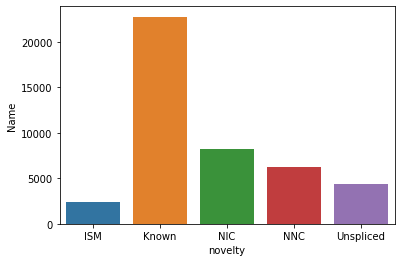

In [17]:
df = ca.ic.loc[ca.ic.source.str.contains('isoquant')].copy(deep=True)
temp = df[['novelty', 'Name']].groupby('novelty').count().reset_index()
sns.barplot(temp, y='Name', x='novelty')

<AxesSubplot:xlabel='novelty', ylabel='Name'>

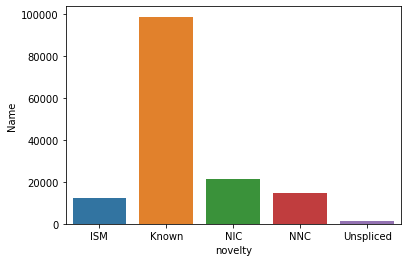

In [18]:
df = ca.ic.loc[ca.ic.source.str.contains('lapa')].copy(deep=True)
temp = df[['novelty', 'Name']].groupby('novelty').count().reset_index()
sns.barplot(temp, y='Name', x='novelty')

## Format IsoQuant abundance file

In [20]:
def format_isoquant_ab(ab, dataset, lib_meta, ofile):
    """
    Format abundance file from isoquant GFF into a format
    that Cerberus can deal with
    """
    meta = pd.read_csv(lib_meta, sep='\t')
    df = pd.read_csv(ab, sep='\t')
    df.head()
    df['annot_transcript_id'] = df['#feature_id']
    df['annot_transcript_name'] = df['annot_transcript_id']
    df['transcript_ID'] = df['annot_transcript_id']
    df.columns = [c.split('.')[0] for c in df.columns]
    df.drop('#feature_id', axis=1, inplace=True)
    m = dict([(entry['ENCODE_alignments_id'], entry['dataset']) for ind, entry in meta[['dataset', 'ENCODE_alignments_id']].iterrows()])
    df.columns = [m[c] if 'ENCFF' in c else c for c in df.columns]
    
    df.to_csv(ofile, sep='\t', index=False)

In [48]:

df.head()


,wtc11_1_1,wtc11_1_3,wtc11_1_2,annot_transcript_id,annot_transcript_name,transcript_ID
0,5.016551,4.130977,10.360410,ENST00000003583.12,ENST00000003583.12,ENST00000003583.12
1,2.315331,1.652391,6.906940,ENST00000003912.7,ENST00000003912.7,ENST00000003912.7
2,27.012200,16.523907,12.662723,ENST00000040877.1,ENST00000040877.1,ENST00000040877.1
3,12.348434,12.117532,18.418507,ENST00000054650.8,ENST00000054650.8,ENST00000054650.8
4,50.165515,40.758970,56.406677,ENST00000054666.10,ENST00000054666.10,ENST00000054666.10


In [34]:
meta = pd.read_csv(lib_meta, sep='\t')
meta.head()

,ENCODE_experiment_id,dataset,sample,sample_display,general_tissue_cell_type,fig1_tissue_label,health_status,tissue_or_cell_line,sample_color_hex_code,matching_mouse_samples,reads_post_talon,ENCODE_alignments_id,ENCODE_reads_id,ENCODE_unfiltered_alignments_id,document_urls,document_labels,platform,RIN,spikeins
0,ENCSR989ZYL,a673_1_1,a673,A673,a673,bone,NaN,cell_line,#de3700,NaN,1330194,ENCFF045ZQI,ENCFF168MIB,ENCFF440LXJ,https://www.encodeproject.org/documents/6d583a...,'ENCODE Long Read RNA-Seq Analysis Protocol fo...,Pacific Biosciences Sequel II,9.8,True
1,ENCSR989ZYL,a673_1_2,a673,A673,a673,bone,NaN,cell_line,#de3700,NaN,1707207,ENCFF320GCF,ENCFF861BKY,ENCFF240FZT,https://www.encodeproject.org/documents/6d583a...,'ENCODE Long Read RNA-Seq Analysis Protocol fo...,Pacific Biosciences Sequel II,9.8,True
2,ENCSR081NRO,adrenal_gland_1_1,adrenal_gland,Adrenal gland,adrenal gland,adrenal gland,NaN,tissue,#e69b00,"adrenal_gland,adrenal_10d,adrenal_14d,adrenal_...",765655,ENCFF147OYL,ENCFF211SQY,ENCFF967OHL,https://www.encodeproject.org/documents/54012f...,'non-size selected cDNA libraries for use in P...,Pacific Biosciences Sequel,9.8,False
3,ENCSR563RLX,adrenal_gland_2_1,adrenal_gland,Adrenal gland,adrenal gland,adrenal gland,NaN,tissue,#e69b00,"adrenal_gland,adrenal_10d,adrenal_14d,adrenal_...",1579294,ENCFF791WUV,ENCFF417ALN,ENCFF900XHI,https://www.encodeproject.org/documents/3baa46...,"'PacBio libraries v3 (October, 2020) Protocol ...",Pacific Biosciences Sequel II,NaN,True
4,ENCSR995WKW,adrenal_gland_3_1,adrenal_gland,Adrenal gland,adrenal gland,adrenal gland,NaN,tissue,#e69b00,"adrenal_gland,adrenal_10d,adrenal_14d,adrenal_...",577077,ENCFF243PFI,ENCFF912HPY,ENCFF020MWV,https://www.encodeproject.org/documents/54012f...,'non-size selected cDNA libraries for use in P...,Pacific Biosciences Sequel,9.4,False
